
Graph Node Info:  [(0, {'element_type': <BondGraphElementTypes.EFFORT_SOURCE: 3>, 'node_index': 0, 'max_ports': 1, 'causality': None, 'params': {}, 'node': <bond_graph_nodes.EffortSource object at 0x1159b6b50>, 'Se': Se_0, 'element_label': 'Se_0'}), (1, {'element_type': <BondGraphElementTypes.ONE_JUNCTION: 6>, 'node_index': 1, 'max_ports': None, 'causality': None, 'params': {}, 'node': <bond_graph_nodes.OneJunction object at 0x1159a9990>, 'element_label': '1_1'}), (2, {'element_type': <BondGraphElementTypes.CAPACITANCE: 0>, 'node_index': 2, 'max_ports': 1, 'causality': <CausalityTypes.INTEGRAL: 0>, 'params': {'C': 10}, 'node': <bond_graph_nodes.Capacitance object at 0x1159ab650>, 'q': q_2, 'element_label': 'C_2'}), (3, {'element_type': <BondGraphElementTypes.INERTANCE: 1>, 'node_index': 3, 'max_ports': 1, 'causality': <CausalityTypes.INTEGRAL: 0>, 'params': {'I': 10}, 'node': <bond_graph_nodes.Inertance object at 0x1159a80d0>, 'p': p_3, 'element_label': 'I_3'})]
______________________

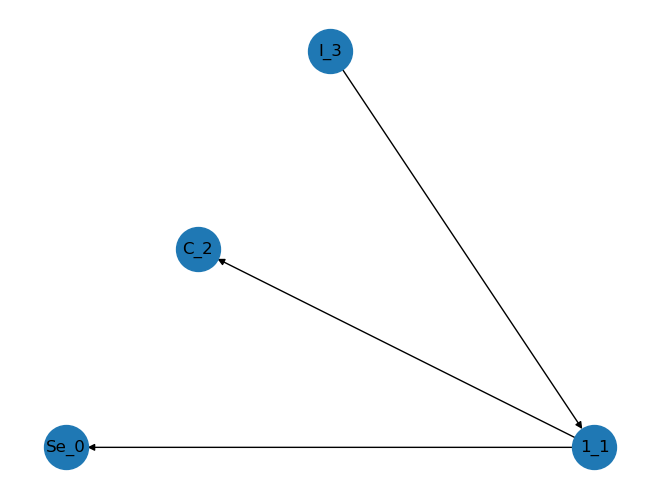

In [137]:
import networkx as nx
import scipy as sp
from bond_graph import *
import time
%reload_ext autoreload
%autoreload 2


G = BondGraph(max_nodes=20, num_states=2)
G.add_element(EffortSource(np.array([1, 2, 3])))
G.add_element(OneJunction())
G.add_bond(1, 0, power_sign=-1)
G.add_element(Capacitance(capacitance=10))
G.add_bond(1, 2, power_sign=1)
G.add_element(Inertance(inertance=10))
G.add_bond(3, 1, power_sign=-1)
# G.add_element(Resistance(resistance=10))
# G.add_bond(1, 4, power_sign=1)
# G.add_element(Capacitance(capacitance=5))
# G.add_bond(1, 4, 1)
# G.add_element(Capacitance(capacitance=10))

# print(list(G.graph.nodes(data=True)))
# print(G.graph.nodes['1_1']['node'].element_type)


labels = nx.get_node_attributes(G.graph, 'element_label')

nx.draw_planar(G.graph, labels=labels, with_labels=True, node_size=1000)

## Time to access energy storage elements (custom class vs. networkx)
# start = time.time()
# energy_storage_elements = G.get_energy_storage_elements()
# end = time.time()

# print(energy_storage_elements)
# print("Custom BG Class Elapsed Time: ", end - start)


# start = time.time()
# energy_storage_elements = [x for x,y in G.graph.nodes(data=True) if y['port_type'] == BondGraphPortTypes.CAPACITANCE or y['port_type'] == BondGraphPortTypes.INERTANCE]
# end = time.time()

# print("Networkx Elapsed Time: ", end - start)
# print(energy_storage_elements)

# print(G.graph.nodes)
# print(nx.to_numpy_array(G.graph))
# print(G.get_port_addition_mask())


print("\nGraph Node Info: ", G.graph.nodes(data=True))

print('_' * 50)
print("\nNode Labels: ")
print(labels)


print("\nStandard Node Order: ")
# print(G.graph.nodes)
print(labels.values())

print("\nPort Addition Mask: ")
print(G.get_element_addition_mask())

causal_adjacency_mask, power_flow_adjacency_mask = G.get_bond_addition_mask()
print("\n Causal Adjacency Mask: ")
print(causal_adjacency_mask)
percent_fill=np.count_nonzero(causal_adjacency_mask)/np.size(causal_adjacency_mask)
print(f"{percent_fill*100:0.2f}% of causal bond actions remain after filtering")

print("\n Power Flow Adjacency Mask: ")
print(power_flow_adjacency_mask)
percent_fill=np.count_nonzero(power_flow_adjacency_mask)/np.size(power_flow_adjacency_mask)
print(f"{percent_fill*100:0.2f}% of power flow bond addition actions remain after filtering")



## SymPy Testing
1. Predefine all symbols at node creation somehow
- Global time symbol t owned by BG class
2. Define expressions for flow/effort at each node
-  Capacitance
    - = 

### EQM Test

In [146]:
from networkx import *
from sympy import *
# print(list(G.graph.successors(1)))

# predefine all symbols at node creation somehow
e0, e1, e2, e3, e4, q2, q4, p3, R4, C2, C4, I3, Se1, t = symbols('e0 e1 e2 e3 e4 q2 q4 p3 R4 C2 C4 I3 Se1 t')

# e2 = e1 + e4

one_junction_list = [e1, -e4, -e2]

p2_equation = Eq(Derivative(q2,t), p3/I3)
q3_equation = Eq(Derivative(p3,t), q2/C2)

#  - R4*p3/I3
pprint(p2_equation)
pprint(q3_equation)


# e2 = e2.subs(e1, Se1)
# e2 = e2.subs(e4 , q4/C4)

# print(e2)
# print(Derivative(e4, t))

d        p₃
──(q₂) = ──
dt       I₃
d        q₂
──(p₃) = ──
dt       C₂


### Gym Env Test

In [1]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
num_node_types = 3
max_nodes = 3
""
add_edge_or_node = spaces.Discrete(2)
node_type_space = spaces.Discrete(num_node_types)
mask = (np.array([1, 0, 0], dtype=np.int8), np.array([1, 1, 1] , dtype=np.int8), np.array([1, 1], dtype=np.int8))
print(mask)
edge_type_space = spaces.MultiDiscrete([max_nodes, max_nodes, 2]) 

edge_type_space.sample(mask=mask)

# action_space = spaces.tuple(node_type_space, edge_type_space)
# action_space.sample(num_nodes=1, num_edges=1)

        

(array([1, 0, 0], dtype=int8), array([1, 1, 1], dtype=int8), array([1, 1], dtype=int8))


array([0, 0, 0])

In [81]:
from bond_graph_env import *
import gymnasium as gym
import numpy as np
from bond_graph import *

max_nodes = 10
num_node_types = len(BondGraphElementTypes)
add_node_or_edge = spaces.Discrete(2) # 0 for add node, 1 for add edge
node_space = spaces.Discrete(num_node_types)        
edge_space = spaces.MultiDiscrete([max_nodes, max_nodes, 2]) 

add_node_or_edge = add_node_or_edge.sample()
add_node_or_edge = int(1)
# print(edge_space.sample())
# print(f"Add Node or Edge: {add_node_or_edge}")
print(add_edge_or_node == int(1))
# if add_node_or_edge == 0:
#     print(node_space.sample())
# elif add_edge_or_node == 1:
#     print(edge_space.sample())

False


### Graph Algorithms Test

[(2, 3), (2, 4), (2, 6), (6, 7)]


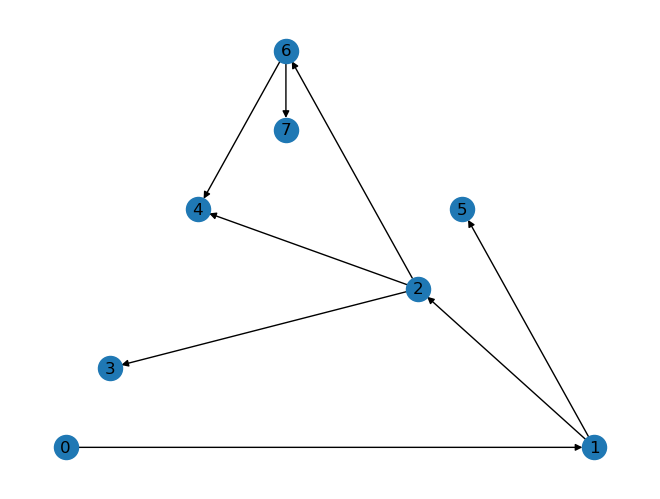

In [14]:
import networkx as nx
G = nx.DiGraph()
G.add_node(0)
G.add_node(1)
G.add_edge(0,1)
H = G.reverse(copy=False)
G.add_node(2)
G.add_edge(1,2)
G.add_node(3)
G.add_edge(2,3)
G.add_edge(1,2)
G.add_edge(1,5)
G.add_edge(2,4)
G.add_edge(2,6)
G.add_edge(6,4)
G.add_edge(6,7)


print(list(nx.dfs_edges(G, source=2, depth_limit=5)))
nx.draw_planar(G, with_labels=True)
# nx.draw_planar(H, with_labels=True)